# Many-body Bell’s inequalities from averaged two-body correlations

Supplementary material for Guillem Müller-Rigat, Albert Aloy, Maciej Lewenstein, Irénée Frérot [arXiv:2012.08474 ](https://arxiv.org/abs/2012.08474). In this notebook we provide a python implementation of the data-driven permutationally-invariant Bell's inequality (PIBI) algorithm with several illustrative examples. The convex-optimization package [cvxpy](https://www.cvxpy.org/install/index.html) is required. 

In [22]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product 
from scipy.optimize import minimize, root_scalar
from scipy.spatial import Delaunay, ConvexHull
from scipy.stats import ortho_group
import random

**Scenario and correlations.** We consider the Bell scenario with $N$ spatially separated observers which perform $q$ distinct $d$-outcome measurments on their parts of a shared state. Our algorithm builds from the partial knowledege of averaged one body and two body correlations

$$m_a=\frac{1}{N}\sum_{i=1}^N\langle f(\mathcal{M}_a^{(i)})\rangle \ , C_{ab}=\frac{1}{N}\sum_{i\neq j}\langle \mathcal{M}_a^{(i)}\mathcal{M}_b^{(j)}\rangle \ \ \forall a,b\in S \subset \{0,1,..,q-1\}\ ,$$

where  $\mathcal{M}_a^{(i)}$ is a $d$-outcome measurement in the ith party with outcomes labeling chosen conventionally $\{-s,-s+1,..,s\}$ with $s=(d-1)/2$. And $\langle \rangle $ dentotes the corresponding expectation value in the shared state. The size of $S$ is $k$, $|S|=k$. $f$ is a function. 

**Note**: In the paper, we used a different convention where the quantities are defined without the $1/N$ prefactor; this convention is however arbitrary. 

In Examples (section 2) a) we will consider correlations data from **spin singlets** with $f(\mathcal{M})=\mathcal{M}^2$ ($p=2$) and in b) from **spin-squeezed states**, with $f(\mathcal{M})=\mathcal{M}$ ($p=1$). Since our method only relies on up to two-body correlations we only require compatibility of these two classes of states at one-body and two-body reduced density matrices level. 

## 1. Outline of the convex optimization algorithm to find a Bell's inequality violated by the input data

Given the statistics $\{C_{ab},m_{b}\}$ we construct the following (cost) function:

$$L(\hat{A},\mathbf{h})=tr(\hat{A}\hat{\tilde{C}})+\mathbf{h}\cdot\mathbf{m}+E_{max}(\hat{A},\mathbf{h}) \ ,$$ 

where $\hat{A}$ is a symmetric, semidefinite matrix with real entries, $\hat{\tilde{C}}$ is the correlation matrix with components $\tilde{C}_{ab}=C_{ab}-m_am_b$, $\mathbf{h}$ is a vector with real components and $\mathbf{m}$ is a vector with components $m_a$. The dimensions of $\{\hat{A}, \mathbf{h}\}$ are given from the size of $S$. The function $E_{max}$ is 

$$E_{max}(\hat{A},\mathbf{h})=\max_\boldsymbol{\sigma} (\boldsymbol{\sigma}^T\hat{A}\boldsymbol{\sigma}-\mathbf{h}\cdot f(\boldsymbol{\sigma}))\le\log(Z(\hat{A},\mathbf{h})) \ ,$$ 

where $\boldsymbol{\sigma}$ is a vector with values $\{-s,-s+1,..,s\}$ with the same dimension as $\mathbf{h}$. And $Z(\hat{A},\mathbf{h})=\sum_{\{\boldsymbol{\sigma}\}}e^{E(\hat{A},\mathbf{h})_\boldsymbol{\sigma}}$ is the partition function.

In [23]:
#We compute E_max by ennumerating the configurations.  

def create_configs(k,s):
    sigma=np.array([[-s+i for i in range(int(2*s+1))]]*k)
    return np.array(list(product(*sigma)))

def L(A, h,p=2):
    E = cp.sum(
        cp.multiply(
            config @ A, config
        ), axis=1
    ) - config**p @ h
    logZ = cp.log_sum_exp(E)
    return cp.sum(cp.multiply(A, Ct)) + h @ m + logZ

As a local determinstic strategy, $-E_{max}$ bounds from below the value of $L$ . Hence,$L\geq 0$ for any local-realistic originated correlations, which in turn define a Bell's inequality (PIBI). Now, we minimize $L$ given $\{ \hat{\tilde{C}},\mathbf{m}\}$ over $\{ \hat{A},\mathbf{h}\}$ with the following semidefinite program (SDP):

$$\min_{\hat{A},\mathbf{m}}L(\hat{A},\mathbf{m}) | A\geq 0, A=A^T$$

If $L<0$, this problem is unfeaseable because $L$ is unbounded (in particular $A\mapsto\lambda A \ , \lambda>1$ will give always a larger minimum), idem for $\mathbf{h}$. After the regularization $||\hat{A}||\leq 1,||\mathbf{h}||\leq 1;|E_{max}|\leq 1$, we can conclude that the given data violates the PIBI

$$L(\hat{A}_{opt},\mathbf{h}_{opt})\equiv \mathcal{B}(\hat{A}_{opt},\mathbf{h}_{opt}) \geq 0 \ , $$ 

where $\{\hat{A}_{opt},\mathbf{h}_{opt}\}$ is a solution of the SDP including the regularization constrain. In general $-E_{max}\geq \mathcal{B}_{c}$, where $\mathcal{B}_{c}$ is the classical bound, but in practice by comparing $E_{max}$ with the classical bound computed analitically, we found in most cases that $E_{max}$ is tight.

In [24]:
def PIBI(Aopt, hopt,p=2):
    Emax = np.max(np.einsum('ij,ik,jk->i', config, config, Aopt) 
        - np.dot(config**p, hopt)
        )
    B = np.sum(Aopt * Ct) + np.sum(hopt * m) + Emax
    return B, Emax

def SDP(Ct, m, verbose=False,p=2):
    #k=len(m)
    A = cp.Variable((k,k), symmetric=True)
    h = cp.Variable((k, ))
    constraints = [A >> 0]
    prob = cp.Problem(cp.Minimize(L(A, h,p=p)),constraints)
    prob.solve()
    if prob.value < 0:          #If L<0 we repeat the problem with the regularization
        if p==2:
            cutoff = 10**10
            constraints += [cp.norm(A,2) <=cutoff]     #operator-norm
            constraints += [cp.max(cp.abs(h)) <=cutoff] 
        if p==1:
            constraints += [cp.max(cp.sum(cp.multiply(config @ A, config), axis=1 ) - config @ h) <= 10]
        prob = cp.Problem(cp.Minimize(L(A, h,p=p)),constraints)
        prob.solve(max_iters = 10000)
    normA=np.linalg.norm(A.value,2)
    A=A.value
    h=h.value
    A/=normA
    h/=normA
    B=PIBI(A, h,p=p)
    if verbose is True:
        if B[0]<0: 
            print("Violation found")
            print("Violation:{}".format(B[0]))
            print("E_max:{}".format(B[1])) 
            print("A:{}".format(A))
            print("h:{}".format(h))
        else:
            print("No violation. Cost function:", prob.value) 
    return B[0],A

 **Measurements.** In this work we will consider $d$-outcome measurements as $s$-dimensional representations of $su(J)$, i.e $\mathcal{M}_a=\mathbf{n}_a\cdot\mathbf{S}$, where $\mathbf{n}_a\in \mathbb{S}_{J^2-2}$ is the Bloch vector and $\mathbf{S}=\sum_{\mu=1}^{J^2-1}S_\mu\mathbf{e}_\mu$. Where the pseudospin-$s$ operators are $\{S_\mu\}_{\mu=1,2..,J^2-1}$ fulfilling the corresponding $SU(J)$ algebra $[S_\mu, S_\nu]=\sum_{\eta=1}^{J^2-1}i\mathcal{E}_{\mu\nu\eta} S_\eta$ and $\{  \mathbf{e}_\mu\}_{\mu=1,2..,J^2-1}$ is an orthonormal basis of $\mathbb{R}^{J^2-1}$. The measurements are implemented individually in each party.

## 2. Examples

### a) Spin-singlets $p=2$

 **Spin-singlets as fully rotation-invariant states**. In general a N-partite $SU(J)$ singlet is defined as the state invariant under the action of the group, $\langle \mathbf{K} \rangle= \langle \mathbf{K}^2 \rangle=0  $, where $\mathbf{K}$ are the collective Casimirs of the group. One of them is the total pseudospin $K=\sum_{i}\mathbf{S}^{2(i)}+2\sum_{i\neq j}\mathbf{S}^{(i)}\mathbf{S}^{(j)}$, where ${S}^2=\sum_{\mu=0}^{J^2}S_\mu^2$ and $\langle {S}^2 \rangle=s(s+1)$. With this information we can readily obtain the correlations:
 
 $$\tilde{C}_{ab}=C_{ab}=-\frac{s(s+1)}{J^2-1}\mathbf{n}_a\cdot\mathbf{n}_b \ \ , m_a=-C_{aa}$$
 
 
In the computation, we also used the other Casimirs which ensure fully total rotational $SO(J-1)$ invariance in the Bloch sphere $\mathbb{R}^{J^2-1}$ and $\sum_i\langle S_a^{(i)} S_b^{(i)} \rangle=0 $ if $\mathbf{n}_a\cdot\mathbf{n}_b=0$. Note $\hat{\tilde{C}}\propto\hat{G}$ where $\hat{G}=\hat{A}^T\hat{A}$ is the Gram matrix and $\hat{A}$ is a $J^2-1\times k$ matrix with the ath column the coefficients of $\mathbf{n}_a$. 

In the following, we will consider in plane measurements, so that we can parametrize them by one angle $\mathbf{n}_a\cdot\mathbf{n}_b=\cos((\theta_a-\theta_b)\pi)$ with $0\leq\theta\leq 1$. First we try random angles, check that for $k=3,4$ nearly for any measurement setting and spin $s=1/2,..,2$ we find violation.    

In [25]:
s=3/2  #spin (level of the representation)
j=2    # group
k=4  #number of measurements

#theta=np.concatenate(([0], np.random.rand(k-1)))  #random angles
theta=np.array([a/k for a in range (k)])  #measurements angles

config=create_configs(k,s)
sz2=s*(s+1)/(j**2-1)

Ct=np.zeros((k, k))
m=np.ones(k)
for a in range(k):
    Ct[a]=-np.cos((theta[a] - theta)*np.pi)

Ct=Ct*sz2
m=m*sz2
    
SDP(Ct, m,verbose=True);

Violation found
Violation:-0.025126158137251053
E_max:0.4390025482695519
A:[[ 4.99999791e-01  3.53553387e-01 -7.98421160e-08 -3.53553068e-01]
 [ 3.53553387e-01  4.99999996e-01  3.53553454e-01 -1.06184446e-08]
 [-7.98421160e-08  3.53553454e-01  5.00000084e-01  3.53553145e-01]
 [-3.53553068e-01 -1.06184446e-08  3.53553145e-01  4.99999881e-01]]
h:[0.9071738  0.90717444 0.90717423 0.90717359]


In particular, for spin $s$ semi-integer and $SU(J=2)$ and measurements at angles $\theta_a=a/k\ , a=0,1,..,k-1$ we discover a PIBI described by $\hat{A}=\hat{G}$ which expands [https://arxiv.org/abs/2004.07796](https://arxiv.org/abs/2004.07796). In order to analize the results, we rewrite the PIBI as a bound on the variance of the collective spin along an arbitrary direction $\mathbf{n}_a$. Assuming $SU(J)$ invariance 

$$0\leq N\mathrm{Var}(S_a)\leq \max(0,-\mathcal{B}(\hat{A},\mathbf{h})/tr(\hat{G}(\mathbf{n})\hat{A})) $$

where $S_a=\frac{1}{N}\sum_iS_a^{(i)}$.

In [26]:
def VarSa(k,s,J):
    [B,A]=SDP(Ct,m)
    vects=np.array([[np.cos(theta[a]*np.pi) for a in range(k)],[np.sin(theta[a]*np.pi) for a in range(k)]])
    G=np.dot(np.transpose(vects),vects)
    VarB=-B/(np.trace(np.dot(G,A)))
    return np.max([0,VarB])


res=np.zeros(10)
s=1/2
j=2

for t in range (10):
    k=2+t
    sz2=s*(s+1)/(j**2-1)
    theta=np.array([a/k for a in range (k)])
    config=create_configs(k,s)
    Ct=np.zeros((k, k))
    m=np.ones(k)
    for a in range(k):
        Ct[a]=-np.cos((theta[a] - theta)*np.pi)
    Ct=sz2*Ct
    m=sz2*m
    res[t]=VarSa(k,s,j)/s    

Text(0.5, 1.0, '$SU(J=2)$ singlet fundamental representation $s=(J-1)/2=1/2$')

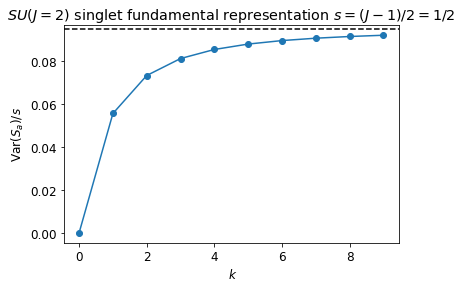

In [27]:
plt.plot(res,'-o')
plt.axhline(y=1/2-4/np.pi**2, color='black', linestyle='dashed')
plt.xlabel(r" $k$")
plt.ylabel(r"$\mathrm{Var}(S_a)/s$")
plt.title(r"$SU(J=2)$ singlet fundamental representation $s=(J-1)/2=1/2$")

For this case represented in the figure, we can compute analytically the asymptoic limit $k\rightarrow\infty$, $\mathrm{var}(S_a)/s\leq 1/2-4/\pi^2\approx 0.095 $ (dashed line). This is useful in the realization of Bell nonlocality certification as Bell correlations using collective measurements. This bound is more restrictive than the entanglement criteria $\mathrm{var}(S_a)/s\leq 1/3\approx 0.333$ from [https://arxiv.org/abs/1310.2269](https://arxiv.org/abs/1310.2269) because of device independence. 


For larger $J$ we observe that the porposed PIBI is no longer the optimal as in some cases the $\mathrm{var}(S_a)$ decreseases with increasing $k$. In general, for $k\geq 4$, one should consider the full $\mathbb{R}^{J^2-1}$ measurement space rather than imposing the in-plane measurement constrain.    

**Additional PIBIs.** Staying at $J=2$, for different measurements we discover different Bell inequalities which are the optimal in a nightborhood of the measurement's parameter space. For instance, for $k=3$, we obtain at least $2s$ PIBIs. This can be verified with the parametrization $\boldsymbol{\theta}=(-T,0,T)\ , 0\leq T\leq 1/2 $.  

In [28]:
j=2
k=3

reso=10
res=np.zeros((reso,4))
T=np.linspace(0.01,0.49,reso)

for spin in range(4):
    s=(spin+1)/2
    sz2=s*(s+1)/(j**2-1)
    for t in range(reso):
        theta=np.array([-T[t],0,T[t]])
        config=create_configs(k,s)
        Ct=np.zeros((k, k))
        m=np.ones(k)
        for a in range(k):
            Ct[a]=-np.cos((theta[a] - theta)*np.pi)
        Ct=sz2*Ct
        m=sz2*m
        res[t,spin]=VarSa(k,s,j) 
    

/home/guillem/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


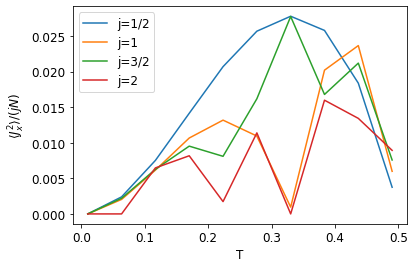

In [29]:
plt.rcParams['font.size'] = '12'

plt.plot(T, res[:,0],label="j=1/2")
plt.plot(T, res[:,1],label="j=1")
plt.plot(T, res[:,2],label="j=3/2")
plt.plot(T, res[:,3],label="j=2")
plt.xlabel("T")
plt.ylabel(r"$\langle J_x^2\rangle/(jN)$")
#plt.title("SU(J=2)")
plt.legend()
plt.savefig('fig.pdf')

Analogouly as the last figure, for higher spin or representation number, becomes more difficult to achieve violation. For $s\leq 2$, modulo trivial redefinition of the measurements, we find PIBIs of the form: 

$$\mathbf{m}_0\cdot\mathbf{m}_1-a\mathbf{m}_0\cdot\mathbf{m}_2+\mathbf{m}_1\cdot\mathbf{m}_2+(\mathbf{diag}(\hat{A})+\mathbf{h})\mathbf{1}+C\geq 0 \ \ ,a=\frac{2s}{2f+1}\ ,f=0,1,..,2s-1 \ .$$

where $C$ is a constant (that does not transform under rotations). The case $a=1$ correspond to the previous PIBI with $k=3$. 

### b) Spin-squeezed states $p=1$

In this section we are going to stick with $J=2$ measurements. We consider states with some mean spin $\langle \mathbf{S}\rangle\neq 0 $. Elementary algebra then allows us to express the intput data as: 

$$\tilde{C}_{ab}=\mathrm{covar}(S_a,S_b)-\langle \{S_a,S_b\} \rangle \ ,  \ \ m_a= \mathbf{n}_a\cdot \langle \mathbf{S}\rangle \ ,$$ 

where $\mathrm{covar}(S_a, S_b)/N=\langle S_a S_b+S_bS_a\rangle/2-\langle S_a\rangle\langle S_b\rangle$ is the (superextensive) covariance matrix of the collective operators $S_a=\frac{1}{N}\sum_{i=1}^N S_a^{(i)}$ and $\{S_a,S_b\}=\frac{1}{N}\sum_{i=1}^N(S_a^{(i)}S_b^{(i)}+S_b^{(i)}S_a^{(i)})/2$, which yelds $1$ for $s=1/2$. We can diagonalize the covariance matrix. Its components are constrained due to the Heinsenberg relation $\mathrm{var}(S_\alpha)\mathrm{var}(S_\beta)\geq | \langle (\mathbf{n}_\alpha\times\mathbf{n}_\beta)\cdot\mathbf{S}  \rangle  |^2/4 $ which is derived from the algebra $[S_\mu^{(i)}, S_\nu^{(j)}]=i\epsilon_{\mu\nu\eta}S_\eta^{(i)}\delta_{ij}$. If a component is below the standard quantum limit, $\mathrm{var}(S_\alpha)<| \langle (\mathbf{n}_\alpha\times\mathbf{n}_\beta)\cdot\mathbf{S}  \rangle |/2$ we say that it is squeezed respect the conjugated component $\mathrm{var}(S_\beta)$ (Ueda).We rescale the parameters to the spin coherent value $\chi^2=\mathrm{var}(S_a)/s^2$ and $r=| \langle (\mathbf{n}_\alpha\times\mathbf{n}_\beta)\cdot\mathbf{S}  \rangle |/s$ so as $\chi^2<|r|/(2s)$

**Recovering Tura et. al. inequality** [https://arxiv.org/abs/1306.6860](https://arxiv.org/abs/1306.6860). In this work we have shown that our alogirthm is able to recover all known PIBIs that can be robustly violated in the thermodynamic limit. Among them the $k=2$ Tura et. al. PIBI which can be obtained by measuring a spin-1/2 squeezed state in a plane containing the mean spin. Conventionally we choose the plane $xy$ with the mean spin $\mathbf{r}$ along the $\mathbf{x}$ direction. The corresponding measurments are parametrized via the angle $\theta\in[0,2\pi)$ as $\{\mathcal{M}_{0/1}=\cos\theta S_x\pm\sin\theta S_y \}$. Consequently, the correlations read: 

$$ \hat{\tilde{C}}=\frac{1}{4}\begin{pmatrix} \chi^2\sin^2\theta-1 & -\chi^2\sin^2\theta-\cos2\theta  \\ -\chi^2\sin^2\theta-\cos2\theta  & \chi^2\sin^2\theta-1  \end{pmatrix} \ , \mathbf{m}=\frac{1}{2}r\cos\theta \begin{pmatrix} 1 \\ 1  \end{pmatrix} \ ,$$ 

where $r=2\langle S_x\rangle$ is the mean spin and $\chi^2=4\mathrm{var}(S_y)$. With this notation, the Wineland spin squeezing criteria is $\chi^2<r^2$ [https://journals.aps.org/pra/abstract/10.1103/PhysRevA.46.R6797](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.46.R6797), which is stricter that the Ueda's spin-squeezing condition and equivalent for $r=1$ (spin coherent state). In fact, this crieria is a multipartite entanglement witness  [https://arxiv.org/abs/quant-ph/0006111](https://arxiv.org/abs/quant-ph/0006111).

In [30]:
#Quantum data 

chi=0.25
r=1

theta=np.arccos(r/(2*(1-chi**2)))  #Actually optimal angle 
Ct=np.array([[chi**2*np.sin(theta)**2-1, -chi**2*np.sin(theta)**2-np.cos(2*theta)],[-chi**2*np.sin(theta)**2-np.cos(2*theta),chi**2*np.sin(theta)**2-1]])/4
m=r*np.cos(theta)*np.array([1,1])/2

#Run the algorithm with 'p=1'

s=1/2
k=2

config=create_configs(k,s)
SDP(Ct, m,verbose=True,p=1);

Violation found
Violation:-0.10208305404863871
E_max:0.5000007696834624
A:[[ 0.49999968 -0.50000032]
 [-0.50000032  0.49999968]]
h:[-0.50000109 -0.50000109]


Violation of Tura et. al. $1-\frac{\mathcal{B}_c}{\mathcal{B}}$. Negative values indicate violation. 

In [31]:
def violation_Tura_et_al(mx, vy):
    def func_ratio_C_Q(theta):   
        return -4 / (
        vy * (2 * np.sin(theta))**2 - 4 * mx * np.cos(theta) 
        - 2 + 2 * np.cos(2 * theta)
        )
    res = minimize(func_ratio_C_Q, x0=0.3)
    return 1 - res.fun

**Tilde versus non-tilde PIBI**. Now that we have introduced finite mean spin, our inequalities will be nonlinear in the probabilities due to the term $\mathbf{m}\otimes\mathbf{m}$ of $\hat{\tilde{C}}$. In the following we compare this type of PIBIs with the conventional ones defined from $\hat{C}$. The procedure basically is: 

In [32]:
n = 10  #number of parties 

1. Local deterministic strategy: generate all vertices of the reduced polytope (after PI) in our convention (outcomes $\pm 1/2$) as set of points p in an affine space $\mathbb{R}^5$ expressed as $[m_0, m_1, C_{00}, C_{01}=C_{10}, C_{11}]$.

In [33]:
listVertices = np.empty((0, 5))

for a in range(0,n+1):
    for b in range(0,n+1):
        for c in range(0,n+1):
            d=n-a-b-c
            if a*b*c*d==0 and d>=0:
                n = a+b+c+d
                s0 = a+b-c-d
                s1 = a-b+c-d
                z = a-b-c+d
                s00 = s0*s0-n
                s01 = s0*s1-z
                s11 = s1*s1-n
                listVertices = np.concatenate([listVertices,[[s0/2,s1/2,s00/4,s01/4,s11/4]]])       
n_vert=np.shape(listVertices)[0] 

2. Center the points around the mean $\mathbf{p}\rightarrow\mathbf{p}-\overline{\mathbf{p}}$. The mean is the sum of all vertices divided by the number of vertices. 

In [34]:
vMix=sum(listVertices)/n_vert  
listVertices=listVertices-np.array([vMix]*n_vert)  #Center around maximally mixed point
ext_coord=int(np.max(listVertices))

3. Choose two random orthonormal vectors of $\mathbb{R}^5$, $\mathbf{x}$ and $\mathbf{y}$

In [35]:
vects=ortho_group.rvs(5)
ran=random.sample(range(5),2)
Proj0=vects[ran[0]]
Proj1=vects[ran[1]]

4. Construct $\mathbf{r}=r\cos(\theta)\mathbf{x}+r\sin(\theta)\mathbf{y}$. For each $\theta$, increase $r$ until $r$ is outside the polytope and assign $r=r(\theta)$ using Dalunay triangulation.(Alternatively, it can be done studying the feasibility of the linear program for $r$ to be expressed as convex combination of vertices).By computing the convex hull of the list of vertices which will be the polytope itself. At the end we have the set of points $(r(\theta)cos(\theta), r(\theta)sin(\theta))=(x,y)$, which define the slice of the polytope in the given plane. 

In [36]:
hull = Delaunay(listVertices)


Reso=300  #resolution
Angles=np.linspace(0, 2*np.pi, Reso)
Rco=np.linspace(0, ext_coord, Reso)

PolX=[]
PolY=[]

for i in range(Reso):
    for j in range(Reso):
        v=Rco[j]*(np.cos(Angles[i])*Proj0+np.sin(Angles[i])*Proj1)
        Feas=hull.find_simplex(v)
        if Feas<0:
            PolX=np.append(Rco[j-1]*np.cos(Angles[i-1]),PolX)
            PolY=np.append(Rco[j-1]*np.sin(Angles[i-1]),PolY)
            break

L=np.min(PolX) 
R=np.max(PolX)

5. We further compute the convex hull of the 2D points $(x,y)$ to eliminate errors which make the contour not look convex. For example, due to the sampling, if the facet and the slice are quite parallel, r(theta) may oscillate between two values for some neighbourhood. This contour is the one that will be plotted and is slightly bigger than the real boundary.

In [37]:
PP=np.array([[PolX[i], PolY[i]] for i in range(len(PolX))])
hull2D=ConvexHull(PP)

6. PIBIs: for the non-tilde we have $\mathcal{B}(x,y)=\mathbf{T}\cdot \mathbf{p}+n$, where $\mathbf{T}=(-1,-1,1,-2,1)^t$ and for the tilde we must add the nonlinear term $-(\mathbf{N}\cdot\mathbf{p})^2$, where $\textbf{N}=(1,-1,0,0,0)^t$. In the figures we plot the curves $B(x,y)=0$, a straight line for the first and a parabola for the latter. 

In [38]:
turavect=np.array([-2, -2, 2, -4, 2])   #+2n
tildevect=np.array([np.sqrt(2), -np.sqrt(2),0, 0, 0])
#x=np.array([i for i in range(2*int(L), 2*int(R))])
x=np.linspace(2*L, 2*R,Reso)

yTura=np.array([(-np.dot(turavect,Proj0)*x[i]-2*n-np.dot(turavect,vMix))/np.dot(turavect,Proj1) for i in range(Reso)])

def Z(x):   
  a=-np.dot(tildevect,Proj1)**2
  b=np.dot(turavect, Proj1)-2*np.dot(tildevect,Proj1)*np.dot(tildevect,Proj0)*(x) 
  c=np.dot(turavect, Proj0)*x+2*n+np.dot(turavect,vMix)-(np.dot(tildevect,Proj0)*x)**2
  return np.array([(-b+np.sqrt(b**2-4*a*c))/(2*a),(-b-np.sqrt(b**2-4*a*c))/(2*a)])


yTildePl=np.array([Z(x[i])[0] for i in range(Reso)])
yTildeMi=np.array([Z(x[i])[1] for i in range(Reso)])


/home/guillem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


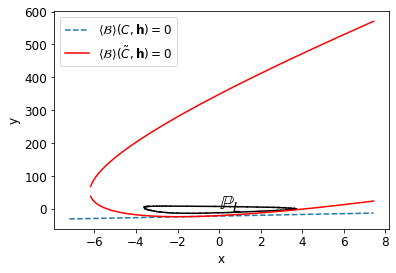

In [39]:
for simplex in hull2D.simplices:
    plt.plot(PP[simplex, 0], PP[simplex, 1], 'k-')
plt.rcParams['font.size'] = '12'
plt.plot(x,yTura, linestyle='dashed',label=r'$\langle \mathcal{B}\rangle (C, \mathbf{h})=0 $' )
plt.plot(x, yTildePl,color='r', label=r'$\langle \mathcal{B}\rangle (\tilde{C}, \mathbf{h})=0 $')
plt.plot(x, yTildeMi,color='r')
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.annotate(r'$\mathbb{P}_L$', xy=(0, 0),size='20')
plt.legend()

In the plot we verify that in general the tilde inequality is better than the non-tilde in the sense that is captable to produce violation for a larger region of the correlation space. Indeed, in most of the cases we observe that it wraps tighly around the local polytope.    

**Improving Tura et. al. 2-outcome PIBI**. We can improve the Tura et. al. inequality by adding an extra measurement in the $\mathbf{y}$ direction which leads to the discovery of the new PIBI defined in terms of its coefficents: 

$$\hat{A}=\begin{pmatrix} 1 & -1 & a \\ -1& 1&-a\\ a &-a & a^2   \end{pmatrix} \ , \mathbf{h}=-\begin{pmatrix} 1+a \\1+a\\0   \end{pmatrix} \ ,$$

with $\mathcal{B}_{class}=-(1+a/2)^2$.For $a=0$ it is equivalent to the Tura et. al. PIBI. In order to optimize $a$, for each value of $(m_x, \mathrm{var}(S_y))$, we maximize the violation.  

In [40]:
def violation_new_PIBI(mx, vy):
    def func_ratio_C_Q(x):
        a, theta = x
        return -(2 + a)**2 / (
        vy * (a + 2 * np.sin(theta))**2 - 4 * mx * (1 + a) * np.cos(theta) 
        - 2 - a**2 + 2 * np.cos(2 * theta) - 4 * a * np.sin(theta)
        )
    res = minimize(func_ratio_C_Q, x0=(1, 0.3))
    return 1 - res.fun

We compare the new PIBI found with Tura et. al.'s in the $(r,\chi^2)$ space

In [41]:
def func_xiR2(mx, vy):
    """squeezing parameter"""
    return vy / mx**2

list_mx = np.concatenate(
    (np.linspace(0.8, 0.98, 100), np.linspace(0.98, 1, 100)
     ))
v_tura = np.zeros_like(list_mx)
v_new = np.zeros_like(list_mx)
v_xiR2 = list_mx**2

for i, mx in enumerate(list_mx):
   def func_new(vy):
       return violation_new_PIBI(mx, vy)
   res = root_scalar(func_new, bracket=[0, 1])
   v_new[i] = res.root
   
   def func_tura(vy):
       return violation_Tura_et_al(mx, vy)
   res = root_scalar(func_tura, bracket=[0, 1])
   v_tura[i] = res.root

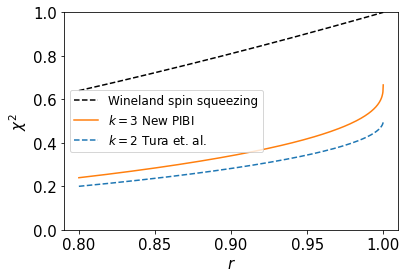

In [42]:
plt.plot(list_mx, v_xiR2, 'k--', label="Wineland spin squeezing")
plt.plot(list_mx, v_new, 'C1-', label=r'$k=3$ New PIBI')
plt.plot(list_mx, v_tura, 'C0--', label=r'$k=2$ Tura et. al.')
plt.ylim(0, 1)
plt.legend(fontsize=12)
plt.xlabel(r"$r $", fontsize=15)
plt.ylabel(r"$\chi^2$", fontsize=15)
plt.tick_params(labelsize=15)

In the figure, entanglement can be certified for correlations lying below the line. We observe that our new $k=3$ PIBI is less restrictive that Tura et. al. and easier to violate from an experimental point of view.

**PIBIs tailored to spin-squeezed states of arbitrary spin**. Finally, for $k=2$ measurement settings, we obtained a PIBI tailored to spin-s many-body squeezed state by considering both linear and quadratic averaged one-body statistics

$$ \mathcal{B}=tr(\hat{A}_{opt}\hat{\tilde{C}})+\mathbf{h}^{(1)}_{opt}\cdot \mathbf{m}^{(1)}+\mathbf{h}^{(2)}_{opt}\cdot\mathbf{m}^{(2)}-\mathcal{B}_{class}\geq0 \ , $$.

where $\mathbf{m}_a^{(1)}=\frac{1}{N}\sum_{i=1}^N\langle S^{(i)}_a \rangle $ is the linear term used in the present notebook when considering spin-1/2 squeezed correlations ($p=1$). In this case we took into account the quadratic one-body term $\mathbf{m}_a^{(2)}=\frac{1}{N}\sum_{i=1}^N\langle S^{2(i)}_a \rangle$ instead ($p=2$).